### Add Fast AI path to environment

In [1]:
import os
import sys
sys.path.append(os.environ.get("FASTAI_PATH"))

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
data_path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
data = (
    ImageList.from_folder(data_path) # images path
    .split_by_folder() # split train and valid datasets by folder
    .label_from_folder()  # get labels from folder name
    .transform(size=28) # resize each image to 28x28
    .databunch(bs=256) # batch size 256
    .normalize(imagenet_stats) # normalize images with mean and std from IMageNet
)

### Train Learner

In [5]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [6]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [7]:
learn.fit_one_cycle(3, 5E-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.094245,0.098276,0.024043,00:04
1,0.040618,0.004187,0.002453,00:03
2,0.016506,0.002773,0.000491,00:03


In [8]:
learn.unfreeze()
best_model = "mnist_sample_resnet34"
learn.fit_one_cycle(10, slice(1E-6, 1E-3), callbacks=[SaveModelCallback(learn, name=best_model, monitor="error_rate", mode="min")])

epoch,train_loss,valid_loss,error_rate,time
0,0.002668,0.004853,0.000981,00:04
1,0.001954,0.003806,0.000981,00:04
2,0.001589,0.004223,0.000981,00:04
3,0.001518,0.005176,0.001472,00:04
4,0.001651,0.001374,0.000981,00:04
5,0.000729,0.003457,0.001472,00:04
6,0.000374,0.002046,0.000981,00:04
7,0.000261,0.002443,0.000981,00:04
8,0.000216,0.002244,0.000491,00:05
9,0.000130,0.002288,0.000491,00:04


Better model found at epoch 0 with error_rate value: 0.0009813610231503844.
Better model found at epoch 8 with error_rate value: 0.0004906843532808125.


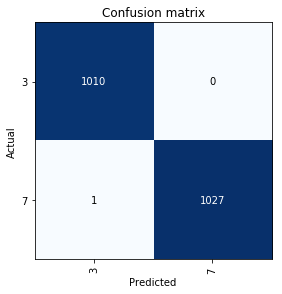

In [9]:
interp = learn.interpret()
interp.plot_confusion_matrix()

### Save Features

This is implemented using `register_forward_hook()` provided by PyTorch ([doc](https://pytorch.org/docs/master/nn.html#torch.nn.Module.register_forward_hook)). The `register_forward_hook()` is called after the module's `forward()`.

Another way is to use `register_forward_pre_hook()` which is called before the module's `forward()`.

In [10]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

Extract the features after the backbone module composed of res-blocks.

In [11]:
sf = SaveFeatures(learn.model[1][1])

In [12]:
y_pos, y_true = learn.get_preds(DatasetType.Valid)
y_true = y_true.numpy()
y_pred = np.argmax(y_pos.numpy(), axis=1)
extracted_features = sf.features
valid_img_path = np.array([str(x) for x in list(data.valid_ds.items)])

In [13]:
extracted_features.shape, y_true.shape

((2038, 1024), (2038,))

#### Visualize the features

In [14]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca')
tsne_features = tsne.fit_transform(extracted_features)

In [15]:
tsne_min, tsne_max = tsne_features.min(0), tsne_features.max(0)
norm_features = (tsne_features - tsne_min) / (tsne_max - tsne_min)

In [16]:
norm_features.shape

(2038, 2)

In [17]:
from matplotlib import pyplot as plt
color_list = np.array(["b", "y"])
marker_list = ["$%s$"%c for c in data.classes]

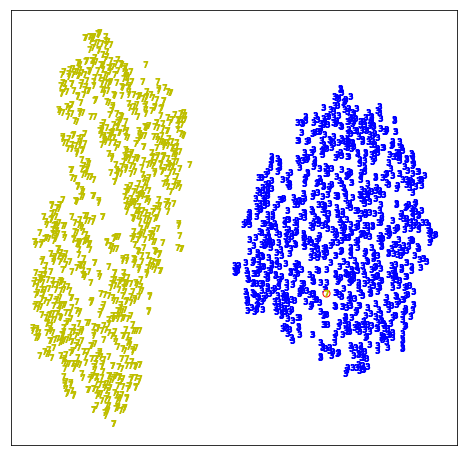

In [18]:
fig = plt.figure(figsize=(8, 8))
for i in range(2):
    plt.scatter(norm_features[y_true==i, 0], norm_features[y_true==i, 1], color=color_list[i], marker=marker_list[i])
for i in range(len(valid_img_path)):
    if y_pred[i] != y_true[i]:
        plt.scatter(norm_features[i, 0], norm_features[i, 1], color="white", marker="o", s=50, edgecolor='r')
        plt.scatter(norm_features[i, 0], norm_features[i, 1], color=color_list[y_true[i]], marker='$%s$'%data.classes[y_true[i]])
plt.xticks([])
plt.yticks([])
plt.show()